In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.utils as vutils
from torchvision.utils import make_grid, save_image
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, clear_output, HTML
from tqdm.notebook import tqdm
import pickle
from pytorch_models import GANFactory as PytorchGANFactory

### Device to Use

In [2]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
elif torch.has_mps:
    device = torch.device("mps")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.
# If 'mps' is printed, it means MPS (GPU for Mac) is available.

cuda


### Dataset to Use

For training the Generative Adverisal Network (GAN), I will be using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which has 50,000 training images. There are 10 classes: *airplane, automobile, bird, cat, deer, dog, frog, horse, ship,* and  *truck*. The goal of this GAN is to generate new images by inputing randomly sampled noise vectors.

In [3]:
# resize to 64x64, and normalize to [-1, 1]
transform = T.Compose([
    T.Resize((64, 64)), 
    T.ToTensor(),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

len(trainset)

Files already downloaded and verified


50000

#### Find the Mean and Standard Deviation to use

In [4]:
# use to find the mean/std of the dataset and normalize the images
def batch_mean_and_sd(dataset):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for image, _ in dataset:
        c, h, w = image.shape
        b_pixels = h * w
        sum_ = torch.sum(image, dim=[1, 2])
        sum_of_square = torch.sum(image ** 2,
                                  dim=[1, 2])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + b_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + b_pixels)
        cnt += b_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std

In [5]:
# train_mean, train_std = batch_mean_and_sd(trainset)
# already calculated
# train_mean = torch.tensor([0.4923, 0.4831, 0.4474])
# train_std = torch.tensor([0.2404, 0.2370, 0.2557])
train_mean = torch.tensor([0.5, 0.5, 0.5])
train_std = torch.tensor([0.5, 0.5, 0.5])
print(train_mean, train_std)

tensor([0.5000, 0.5000, 0.5000]) tensor([0.5000, 0.5000, 0.5000])


In [6]:
# remake dataset with new normalization
transforms = T.Compose([
    T.Resize((64, 64)),
    T.CenterCrop((64, 64)),
    T.ToTensor(),
    T.Normalize(train_mean, train_std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified


### Save Directories

In [7]:
# where to store generated images
sample_dir = 'data/generated-rc-cgan3'
os.makedirs(sample_dir, exist_ok=True)
# where to store models and losses
models_dir = os.path.join('modelss', 'RC-cGAN3')
os.makedirs(models_dir, exist_ok=True)
# where to store video
video_filepath = os.path.join(sample_dir, 'gan_training.avi')

### Helper Functions for Visualization

In [8]:
def denorm(img):
    out = img * train_std[:, None, None] + train_mean[:, None, None]
    return out

# The function to show an image.
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], normalize=True).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    images, _ = next(iter(dl))
    show_images(images, nmax)

os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, generator, fixed_latent_inputs, fixed_labels, show=True):
    # generate fake_images
    fake_images = generator(fixed_latent_inputs, fixed_labels).to('cpu')
    # save fake_images
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8, normalize=True)
    
    if show:
        show_images(fake_images)

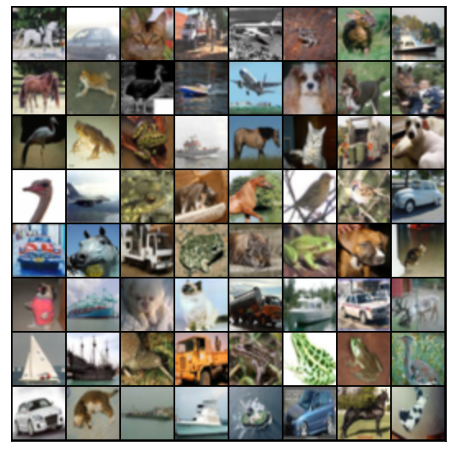

In [9]:
# show sample images
show_batch(trainloader)

### Training Functions

#### Training the Discriminator

In [10]:
def train_discriminator(discriminator, generator, criterion, d_opt, real_images, latent_input, labels):
    # reset gradients
    d_opt.zero_grad()

    # pass real images to discriminator
    real_preds = discriminator(real_images, labels)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = criterion(real_preds, real_targets)
    # want real_score to be good
    real_score = torch.mean(real_preds).item()

    # create fake_images
    fake_images = generator(latent_input, labels)

    # pass fake images to discriminator
    fake_preds = discriminator(fake_images, labels)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = criterion(fake_preds, fake_targets)
    # want fake_score to be bad
    fake_score = torch.mean(fake_preds).item()

    # update discriminator
    loss = real_loss + fake_loss
    loss.backward()
    d_opt.step()

    return loss.item(), real_score, fake_score

#### Training the Generator

In [11]:
def train_generator(discriminator, generator, criterion, g_opt, latent_input, labels):
    # reset gradients
    g_opt.zero_grad()

    # create fake_images
    fake_images = generator(latent_input, labels)

    # pass fake images to fool discriminator - make discriminator think they are real
    preds = discriminator(fake_images, labels)
    target = torch.ones(fake_images.shape[0], 1, device=device)
    loss = criterion(preds, target)

    # update generator 
    loss.backward()
    g_opt.step()

    return loss.item(), fake_images.to('cpu')

### Training Process

#### Hyperparameters

In [12]:
# hyperparameters
batch_size = 128
latent_size = 128
learning_rate = 0.001
epochs = 50

#### Initialize Trainloader

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=3)

#### Initialize Models

In [14]:
params = {
    "latent_size": latent_size,
    "num_classes": 10,
    "resnet_type": 18,
    "layers": [2, 2, 2, 2, 2],
    "device": device
}
# DC-GAN, DC-cGAN, RC-cGAN
discriminator, generator = PytorchGANFactory().get_model('RC-cGAN', params)
print(generator)

ResGenerator(
  (emb): Embedding(10, 10)
  (conv1): Sequential(
    (0): ConvTranspose2d(138, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer0): Sequential(
    (0): GenBlock(
      (conv1): ConvTranspose2d(1024, 768, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): ConvTranspose2d(1024, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): ConvTranspose2d(768, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): ConvTranspose2d(1024, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

#### Define the Loss Function and Optimizer

In [15]:
criterion = nn.BCELoss()

# optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

#### Train

In [16]:
def train(discriminator, generator, d_optimizer, g_optimizer, prev_data = None, index=0):

    torch.cuda.empty_cache()

    if prev_data:
        losses_d = prev_data['losses_d']
        losses_g = prev_data['losses_g']
        real_scores = prev_data['real_scores']
        fake_scores = prev_data['fake_scores']
        img_list = []
    else:
        losses_d = []
        losses_g = []
        real_scores = []
        fake_scores = []
        img_list = []

    # fixed_latent_inputs = torch.randn(batch_size, latent_size, 1, 1, device=device)
    # fixed_labels = torch.randint(0, 10, (batch_size,), device=device)

    # torch.save(fixed_latent_inputs, 'fixed_latent_inputs.pt')
    # torch.save(fixed_labels, 'fixed_latent_labels.pt')

    fixed_latent_inputs = torch.load('fixed_latent_inputs.pt', map_location=device)
    fixed_labels = torch.load('fixed_latent_labels.pt', map_location=device)

    for epoch in tqdm(range(epochs)):
        for n, (real_images, labels) in enumerate(trainloader):
            real_images = real_images.to(device)
            labels = labels.to(device)

            latent_input = torch.randn(real_images.shape[0], latent_size, 1, 1, device=device)

            # train discriminator
            d_output = train_discriminator(discriminator, generator, criterion, 
                                        d_optimizer, real_images, latent_input,
                                        labels)

            d_loss, real_score, fake_score = d_output

            # train generator
            g_loss, fake_images = train_generator(discriminator, generator, 
                                                criterion, g_optimizer, 
                                                latent_input, labels)

            losses_d.append(d_loss)
            losses_g.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            if n % 300 == 0 or (epoch == epochs-1 and n == len(trainloader)-1):
                print(f'Epoch: {epoch} | Batch: {n} | d_loss: {d_loss:.4f} | g_loss: {g_loss:.4f} | D(x): {real_score:.4f} | D(G(z)): {fake_score:.4f}')
                img_list.append(make_grid(fake_images[:64], padding=2, normalize=True))
                save_samples(index, generator, fixed_latent_inputs, fixed_labels, show=False)
                index += 1
            # if epoch == epochs-1 and n == len(trainloader)-1:
            #     save_samples(index, generator, fixed_latent_inputs, fixed_labels, show=True)
    
    # save model
    torch.save(generator.state_dict(), os.path.join(models_dir, 'generator.pth'))
    print("Saved generator!")
    torch.save(discriminator.state_dict(), os.path.join(models_dir, 'discriminator.pth'))
    print("Saved discriminator!")
    # Save losses and scores
    torch.save(losses_g, os.path.join(models_dir, 'losses_g.pkl'), pickle_module=pickle)
    print("Saved losses_g!")
    torch.save(losses_d, os.path.join(models_dir, 'losses_d.pkl'), pickle_module=pickle)
    print("Saved losses_d!")
    torch.save(real_scores, os.path.join(models_dir, 'real_scores.pkl'), pickle_module=pickle)
    print("Saved real_scores!")
    torch.save(fake_scores, os.path.join(models_dir, 'fake_scores.pkl'), pickle_module=pickle)
    print("Saved fake_scores!")

    return {
        "losses_g": losses_g, 
        "losses_d": losses_d, 
        "real_scores": real_scores, 
        "fake_scores": fake_scores, 
        "img_list": img_list
    }

In [17]:
# training new model
data = train(discriminator, generator, d_optimizer, g_optimizer)

losses_d, losses_g, real_scores, fake_scores, img_list = data['losses_d'], data['losses_g'], data['real_scores'], data['fake_scores'], data['img_list']

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0 | d_loss: 1.5244 | g_loss: 2.0563 | D(x): 0.4725 | D(G(z)): 0.4711
Epoch: 0 | Batch: 300 | d_loss: 2.3932 | g_loss: 3.9171 | D(x): 0.2701 | D(G(z)): 0.0070
Epoch: 1 | Batch: 0 | d_loss: 1.0981 | g_loss: 1.6384 | D(x): 0.6974 | D(G(z)): 0.4530
Epoch: 1 | Batch: 300 | d_loss: 0.8433 | g_loss: 3.5061 | D(x): 0.7810 | D(G(z)): 0.4008
Epoch: 2 | Batch: 0 | d_loss: 1.1185 | g_loss: 2.2018 | D(x): 0.6218 | D(G(z)): 0.3975
Epoch: 2 | Batch: 300 | d_loss: 1.3370 | g_loss: 1.5173 | D(x): 0.5212 | D(G(z)): 0.4129
Epoch: 3 | Batch: 0 | d_loss: 1.1968 | g_loss: 2.0387 | D(x): 0.4919 | D(G(z)): 0.3021
Epoch: 3 | Batch: 300 | d_loss: 1.2250 | g_loss: 1.8725 | D(x): 0.4874 | D(G(z)): 0.3128
Epoch: 4 | Batch: 0 | d_loss: 0.9420 | g_loss: 2.2307 | D(x): 0.5331 | D(G(z)): 0.2085
Epoch: 4 | Batch: 300 | d_loss: 1.1843 | g_loss: 2.0111 | D(x): 0.5735 | D(G(z)): 0.3842
Epoch: 5 | Batch: 0 | d_loss: 1.3220 | g_loss: 1.7328 | D(x): 0.3842 | D(G(z)): 0.1794
Epoch: 5 | Batch: 300 | d_loss: 1

Epoch: 46 | Batch: 300 | d_loss: 0.2626 | g_loss: 3.4869 | D(x): 0.8438 | D(G(z)): 0.0554
Epoch: 47 | Batch: 0 | d_loss: 1.5802 | g_loss: 6.9715 | D(x): 0.9809 | D(G(z)): 0.7097
Epoch: 47 | Batch: 300 | d_loss: 0.4801 | g_loss: 2.6351 | D(x): 0.8065 | D(G(z)): 0.1735
Epoch: 48 | Batch: 0 | d_loss: 0.7493 | g_loss: 3.0470 | D(x): 0.7811 | D(G(z)): 0.3172
Epoch: 48 | Batch: 300 | d_loss: 0.7281 | g_loss: 3.0459 | D(x): 0.7875 | D(G(z)): 0.3199
Epoch: 49 | Batch: 0 | d_loss: 0.3558 | g_loss: 3.4502 | D(x): 0.8054 | D(G(z)): 0.0867
Epoch: 49 | Batch: 300 | d_loss: 1.9333 | g_loss: 5.0104 | D(x): 0.2519 | D(G(z)): 0.0076
Epoch: 49 | Batch: 390 | d_loss: 0.1521 | g_loss: 3.1869 | D(x): 0.9564 | D(G(z)): 0.0942
Saved generator!
Saved discriminator!
Saved losses_g!
Saved losses_d!
Saved real_scores!
Saved fake_scores!


### Function to load previous models for more training

In [18]:
# load data
def load_data(dir, discriminator, generator):
    # get loss data
    losses_d = torch.load(os.path.join(dir, 'losses_d.pkl'))
    losses_g = torch.load(os.path.join(dir, 'losses_g.pkl'))
    real_scores = torch.load(os.path.join(dir, 'real_scores.pkl'))
    fake_scores = torch.load(os.path.join(dir, 'fake_scores.pkl'))
    # get model data
    discriminator.load_state_dict(torch.load(os.path.join(dir, 'discriminator.pth')))
    generator.load_state_dict(torch.load(os.path.join(dir, 'generator.pth')))
    return {
        "losses_d": losses_d, 
        "losses_g": losses_g, 
        "real_scores": real_scores, 
        "fake_scores": fake_scores,
        "discriminator": discriminator,
        "generator": generator
    }

In [19]:
# where to store generated images
sample_dir = 'data/generated-rc-cgan4'
os.makedirs(sample_dir, exist_ok=True)
# where to store models and losses
models_dir = os.path.join('modelss', 'RC-cGAN4')
os.makedirs(models_dir, exist_ok=True)
video_filepath = os.path.join(sample_dir, 'gan_training.avi') # where to store video

# load data
discriminator, generator = PytorchGANFactory().get_model('RC-cGAN', params)
prev_model_dir = os.path.join('modelss', 'RC-cGAN3')
prev_data = load_data(prev_model_dir, discriminator, generator)
discriminator = prev_data['discriminator']
generator = prev_data['generator']

# set optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 20
data = train(discriminator, generator, d_optimizer, g_optimizer, prev_data=prev_data, index=61)

losses_d, losses_g, real_scores, fake_scores, img_list = data['losses_d'], data['losses_g'], data['real_scores'], data['fake_scores'], data['img_list']

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0 | d_loss: 0.8265 | g_loss: 1.9007 | D(x): 0.9623 | D(G(z)): 0.4950
Epoch: 0 | Batch: 300 | d_loss: 0.4832 | g_loss: 2.4986 | D(x): 0.7434 | D(G(z)): 0.1158
Epoch: 1 | Batch: 0 | d_loss: 0.4860 | g_loss: 2.1486 | D(x): 0.8968 | D(G(z)): 0.2714
Epoch: 1 | Batch: 300 | d_loss: 0.5557 | g_loss: 2.1106 | D(x): 0.8038 | D(G(z)): 0.2094
Epoch: 2 | Batch: 0 | d_loss: 0.4303 | g_loss: 2.6531 | D(x): 0.8210 | D(G(z)): 0.1524
Epoch: 2 | Batch: 300 | d_loss: 0.5609 | g_loss: 2.3916 | D(x): 0.7791 | D(G(z)): 0.2008
Epoch: 3 | Batch: 0 | d_loss: 0.5175 | g_loss: 2.4978 | D(x): 0.7939 | D(G(z)): 0.1817
Epoch: 3 | Batch: 300 | d_loss: 0.6645 | g_loss: 2.4618 | D(x): 0.8336 | D(G(z)): 0.2903
Epoch: 4 | Batch: 0 | d_loss: 0.7889 | g_loss: 3.6458 | D(x): 0.9558 | D(G(z)): 0.4535
Epoch: 4 | Batch: 300 | d_loss: 0.5377 | g_loss: 2.5412 | D(x): 0.7722 | D(G(z)): 0.1157
Epoch: 5 | Batch: 0 | d_loss: 1.1990 | g_loss: 3.5382 | D(x): 0.9291 | D(G(z)): 0.6105
Epoch: 5 | Batch: 300 | d_loss: 0

### Save photos as video

In [20]:
# video form of the transformation
import cv2 

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if f.endswith('.png')]
files.sort()

out = cv2.VideoWriter(video_filepath, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


### Visualize Loss Function

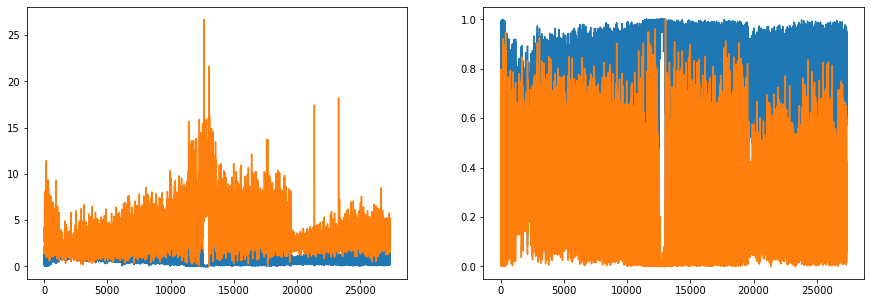

In [21]:
# plot the losses
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_d, label='Discriminator')
ax[0].plot(losses_g, label='Generator')
ax[1].plot(real_scores, label='Real')
ax[1].plot(fake_scores, label='Fake')